#GE-461 Project 5 Data Stream
Prepared by Bahadır Yüzlü

##Requirements

In [1]:
!pip install scikit-multiflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.6/450.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-multiflow: filename=scikit_multiflow-0.5.3-cp310-cp310-linux_x86_64.whl size=1254826 sha256=100e60eb2bf4c764af9d374e37683609f4d00b327910ac2fbc585422fb193b29
  Stored in directory: /root/.cache/pip/wheels/6e/1b/56/45b17a6cf203d98000a45976cb0dd0c4c3f11960e6a505f231
Successfully built scikit-multiflow


In [2]:
!pip install "numpy<1.24"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 47.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy 1.23.5 which is incompatible.


In [1]:
import numpy as np
from google.colab import drive
import pandas as pd
from skmultiflow.data import AGRAWALGenerator, SEAGenerator
from skmultiflow.lazy import SAMKNNClassifier
from skmultiflow.meta import AdaptiveRandomForestClassifier, DynamicWeightedMajorityClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from matplotlib.patches import Rectangle
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.drift_detection import ADWIN

##A) Dataset Preparation

In [2]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!ls "/content/drive/My Drive/GE-461/Project 5"

AGRAWALDataset.csv  datastreamcode  datastreamcode.ipynb  elec.csv  SEADataset.csv  spam.csv


In [4]:
# Function to generate and save synthetic data stream
def generate_and_save_data(generator, filename):
    drift_points_interval = [25000, 25000, 25000, 25000]
    df = pd.DataFrame()
    for i in drift_points_interval:
        X, y = generator.next_sample(i)
        # Add Drift
        generator.generate_drift()
        # Combine features (X) and labels (y) into a DataFrame
        data_df = pd.DataFrame(np.hstack((X, np.array([y]).T)))
        # Concatenate the new DataFrame with the existing DataFrame (df)
        df = pd.concat([data_df, df], ignore_index=True)
    # Specify the filename with the full path in Google Drive
    filepath = f'/content/drive/My Drive/GE-461/Project 5/{filename}'
    # Save the DataFrame to a CSV file in Google Drive
    df.to_csv(filepath, index=False)
    return df

In [5]:
# Generate and save AGRAWALDataset with concept drift
agrawal = AGRAWALGenerator()
agrawal_df = generate_and_save_data(agrawal, "AGRAWALDataset.csv")

In [6]:
# Generate and save SEADataset with concept drift
sea = SEAGenerator()
sea_df = generate_and_save_data(sea, "SEADataset.csv")

In [7]:
# Specify the path to the directory containing the datasets
directory_path = '/content/drive/My Drive/GE-461/Project 5/'

# File names of the datasets
spam_filename = 'spam.csv'
elec_filename = 'elec.csv'

# Load the datasets into pandas DataFrames
spam_df = pd.read_csv(directory_path + spam_filename)
elec_df = pd.read_csv(directory_path + elec_filename)

##B) Implementations for Handling Concept Drift

###1) Implement an instance of the following classification models available on scikit-multiflow.

In [ ]:
def classifier(df, clf, df_name, clf_name, window_size=1000):
    # Initialize variables for prequential accuracy calculation
    accuracies = []
    total_accuracy = 0
    total_instances = 0
    chunk_number = 0
    preq_acc_values = []

    # Interleaved Test-Then-Train evaluation loop
    for index, row in df.iterrows():
        X = np.array([row.iloc[:-1]])
        y = np.array([row.iloc[-1]])

        # Perform prediction
        y_pred = clf.predict(X)

        # Update classifier with current sample
        clf.partial_fit(X, y)

        # Calculate accuracy
        instance_accuracy = accuracy_score(y, y_pred)
        accuracies.append(instance_accuracy)

        # Update overall accuracy
        total_accuracy += instance_accuracy
        total_instances += 1

        # Calculate prequential accuracy for sliding window
        if len(accuracies) % window_size == 0:
            prequential_accuracy = sum(accuracies[-window_size:]) / window_size
            preq_acc_values.append(prequential_accuracy)

        # Increment chunk number
        chunk_number += 1

    # Calculate overall accuracy
    overall_accuracy = total_accuracy / total_instances

    # Calculate the number of chunks
    num_chunks = len(preq_acc_values)

    # Determine the figure width based on the number of chunks
    if num_chunks < 100:
        fig_width = 10
    else:
        fig_width = num_chunks * 0.1

    # Plot prequential accuracy as a line graph
    plt.figure(figsize=(fig_width, 6))
    plt.plot(np.arange(num_chunks), preq_acc_values, color='b', label='Prequential Accuracy')
    plt.axhline(overall_accuracy, color='r', linestyle='--', label='Overall Accuracy')
    plt.title(f"Prequential Accuracy of {clf_name} with {df_name}", fontsize=14)
    plt.xlabel("Chunk Number", fontsize=10)
    plt.ylabel("Prequential Accuracy", fontsize=10)
    plt.text(num_chunks + 0.1 * num_chunks, overall_accuracy, f'Overall Accuracy: {overall_accuracy:.4f}', fontsize=10, color='black')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# List of DataFrames and their names
datasets = [
    (spam_df, 'Spam Dataset'),
    (elec_df, 'Electric Dataset'),
    (agrawal_df, 'Agrawal Dataset'),
    (sea_df, 'Sea Dataset')
]

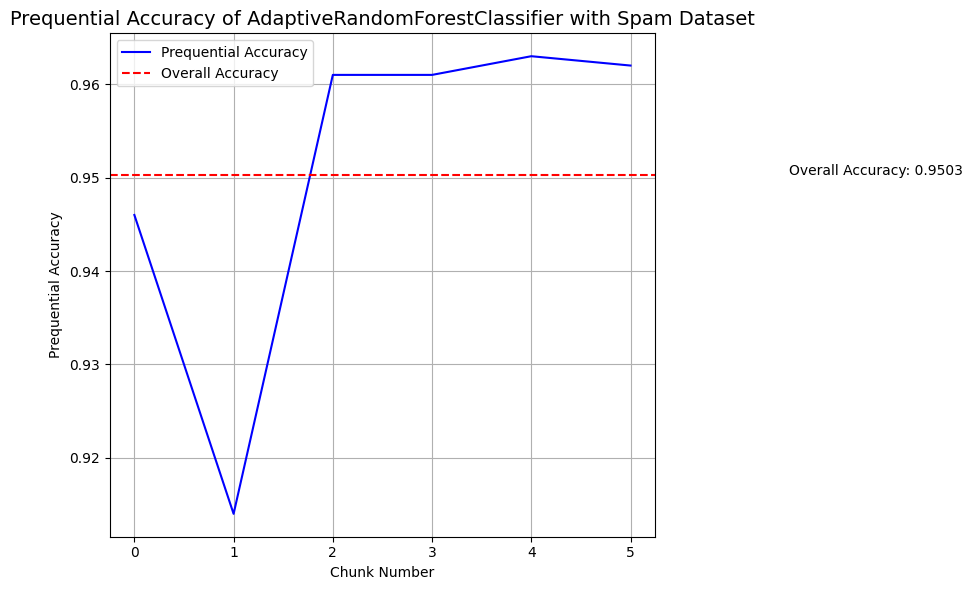

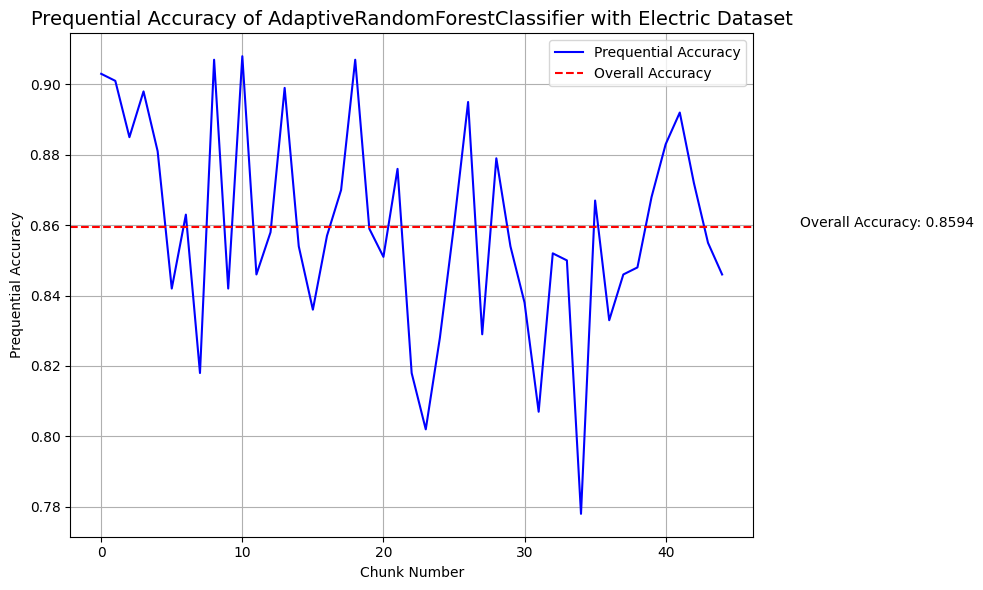

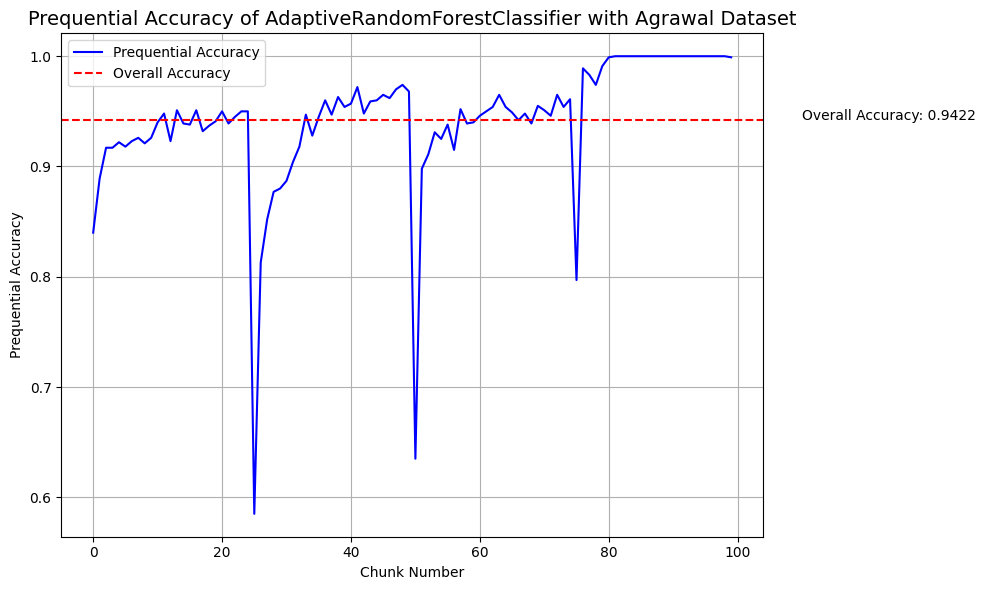

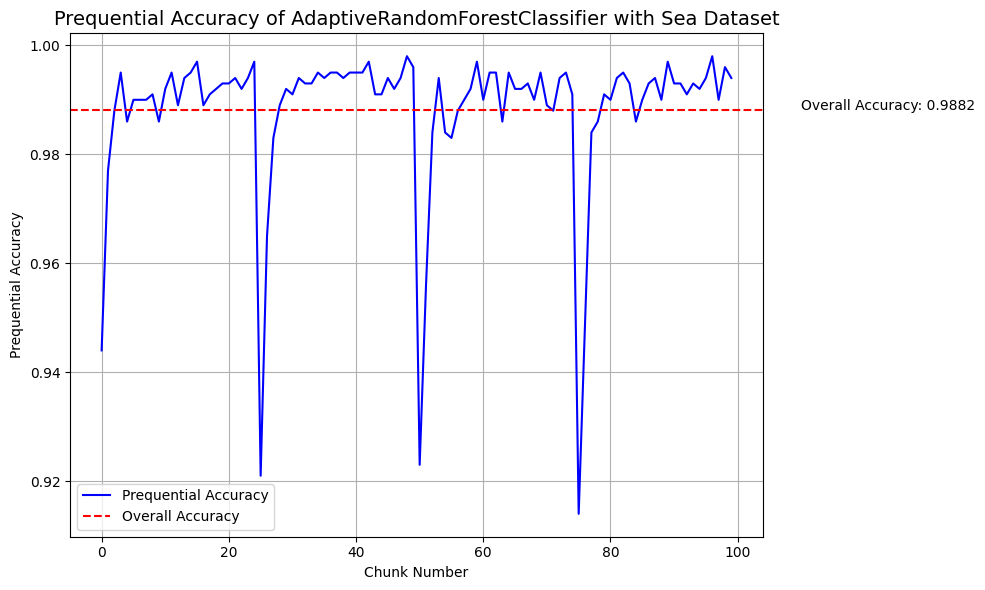

In [ ]:
# Evaluate each DataFrame with multiple classifiers
for df, df_name  in datasets:
    classifier(df, AdaptiveRandomForestClassifier(), df_name, 'AdaptiveRandomForestClassifier')

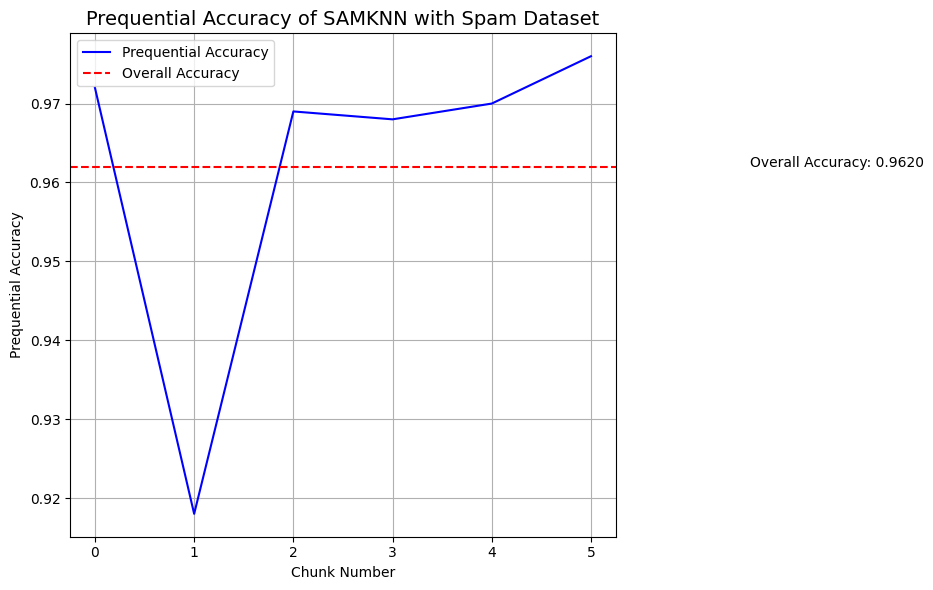

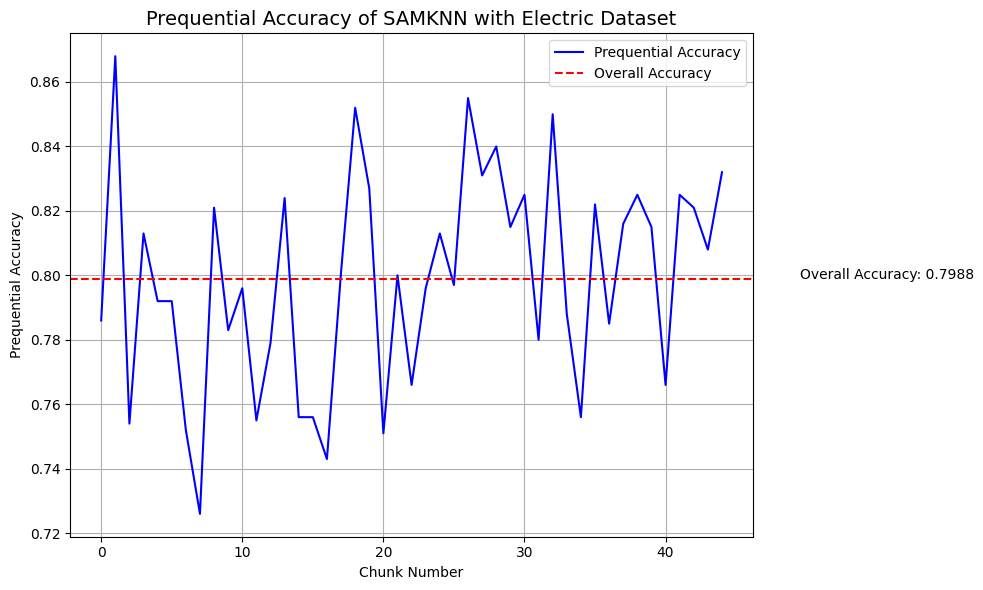

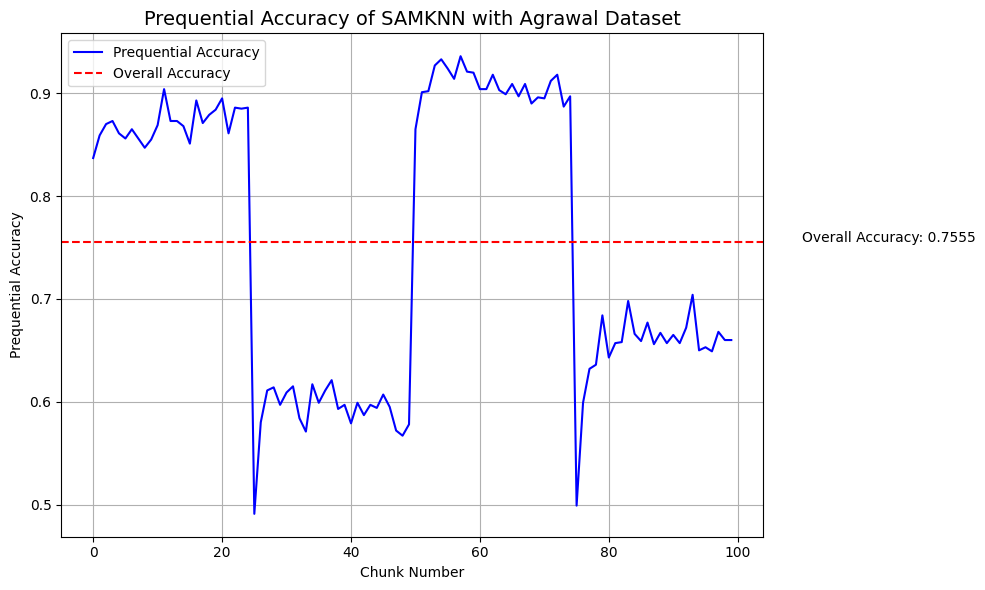

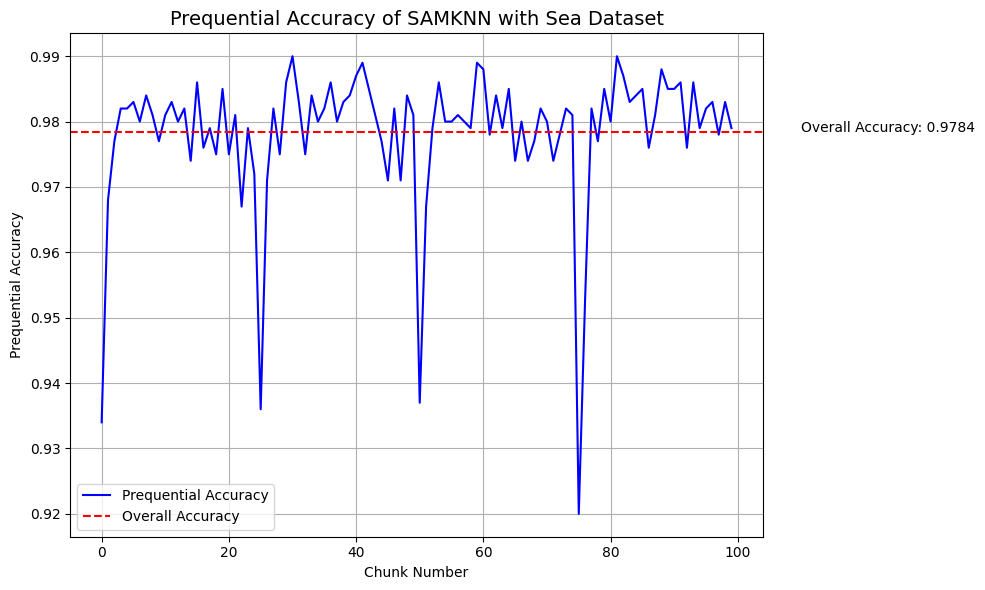

In [ ]:
# Evaluate each DataFrame with multiple classifiers
for df, df_name  in datasets:
    classifier(df, SAMKNNClassifier(), df_name, 'SAMKNN')

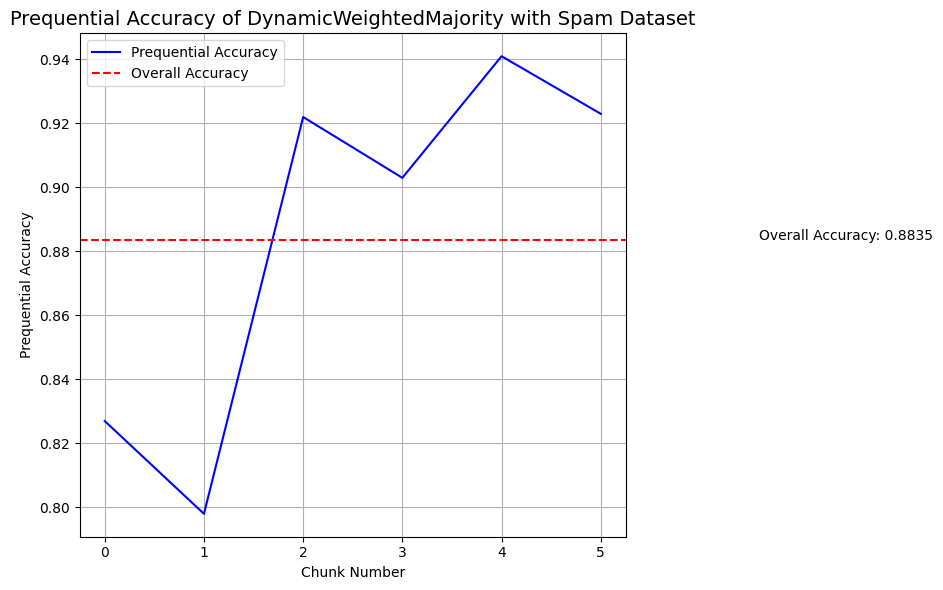

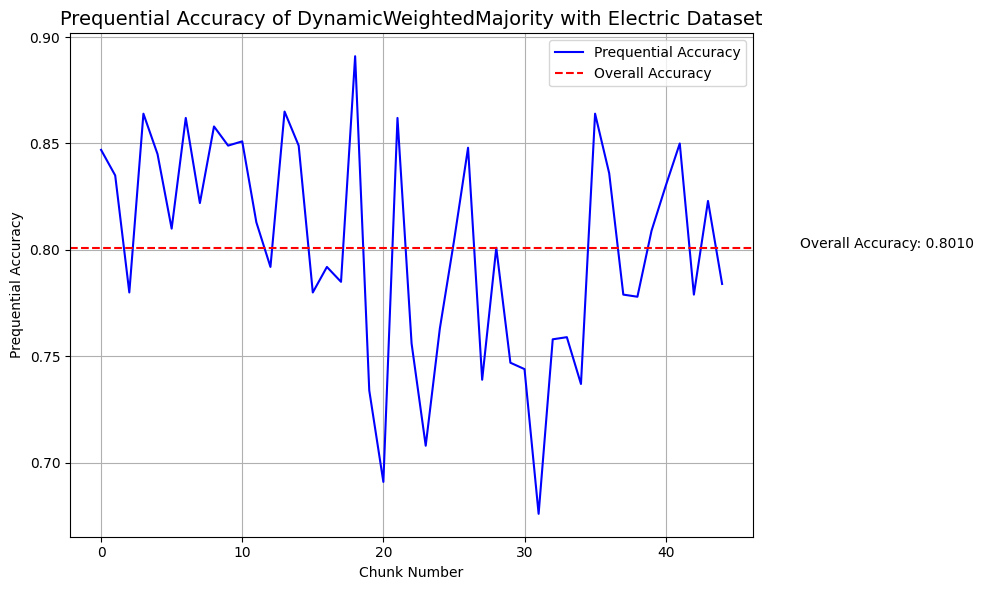

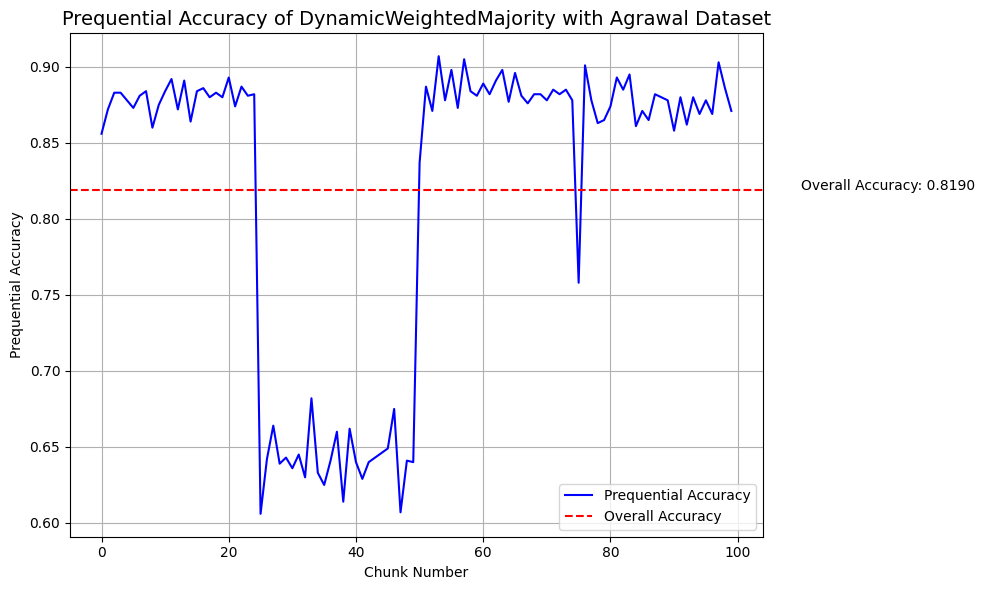

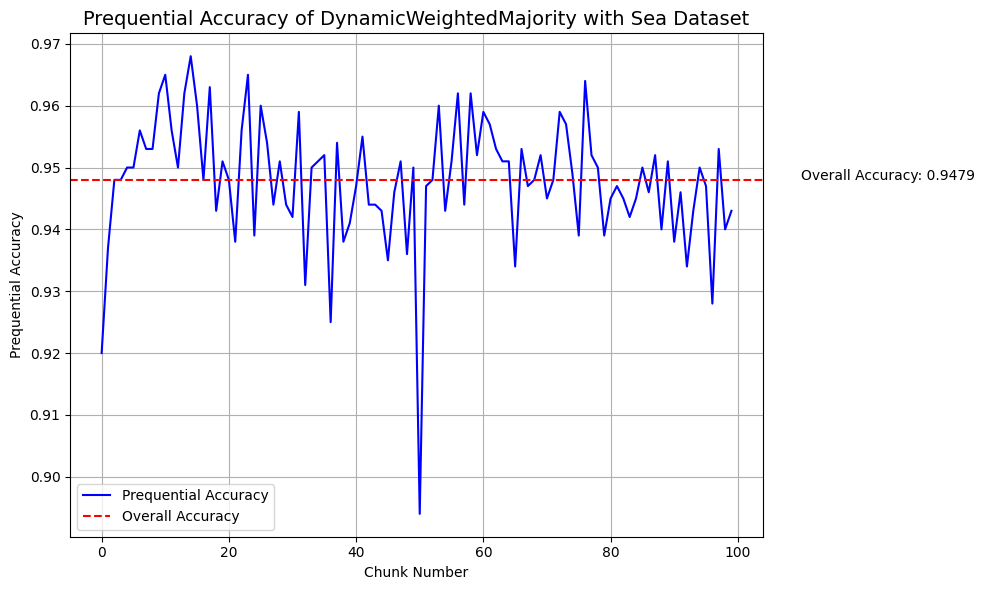

In [ ]:
# Evaluate each DataFrame with multiple classifiers
for df, df_name  in datasets:
    classifier(df, DynamicWeightedMajorityClassifier(), df_name, 'DynamicWeightedMajority')

###2) Build your own ensemble from scratch.

In [ ]:
def initialize_ensemble(num_learners):
    base_learners = [HoeffdingTreeClassifier() for _ in range(num_learners)]
    drift_detector = ADWIN()
    return base_learners, drift_detector

def partial_fit_ensemble(base_learners, drift_detector, X, y):
    for classifier in base_learners:
        # Update the classifier with the current sample
        clf = classifier.partial_fit(X, y)
    # Make predictions on the updated classifiers
    y_pred = predict_ensemble(base_learners, X)

    drift_detector.add_element(1 if (y_pred == y).all else 0)

    # Check for concept drift using the drift detector
    if drift_detector.detected_change():
        # Reset all base learners if drift is detected
        for classifier in base_learners:
            classifier.reset()

def predict_ensemble(base_learners, X):
    # Collect predictions from each base learner
    predictions = [learner.predict(X) for learner in base_learners]

    # Convert list of predictions into a NumPy array
    predictions_array = np.array(predictions)

    # Find the unique predictions and their counts
    unique_predictions, counts = np.unique(predictions_array, return_counts=True, axis=0)

    # Determine the index of the prediction with the highest count
    majority_index = np.argmax(counts)

    # Get the majority prediction based on the index
    majority_prediction = unique_predictions[majority_index]

    return majority_prediction


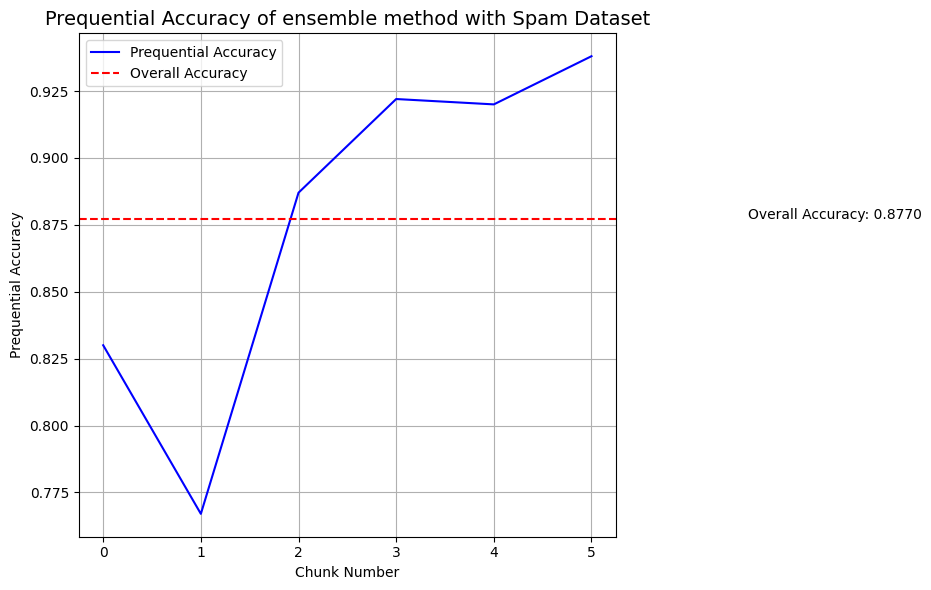

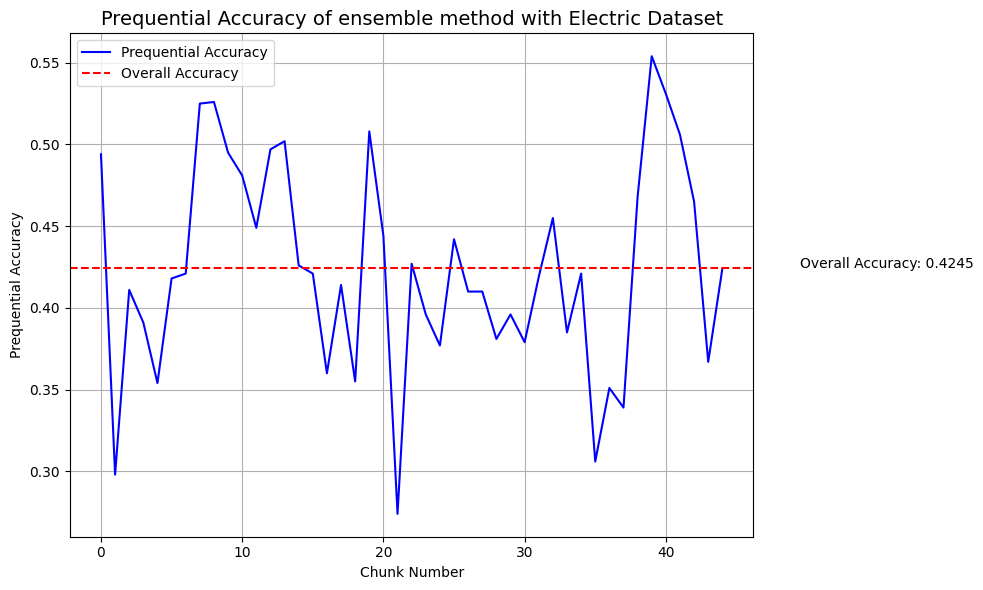

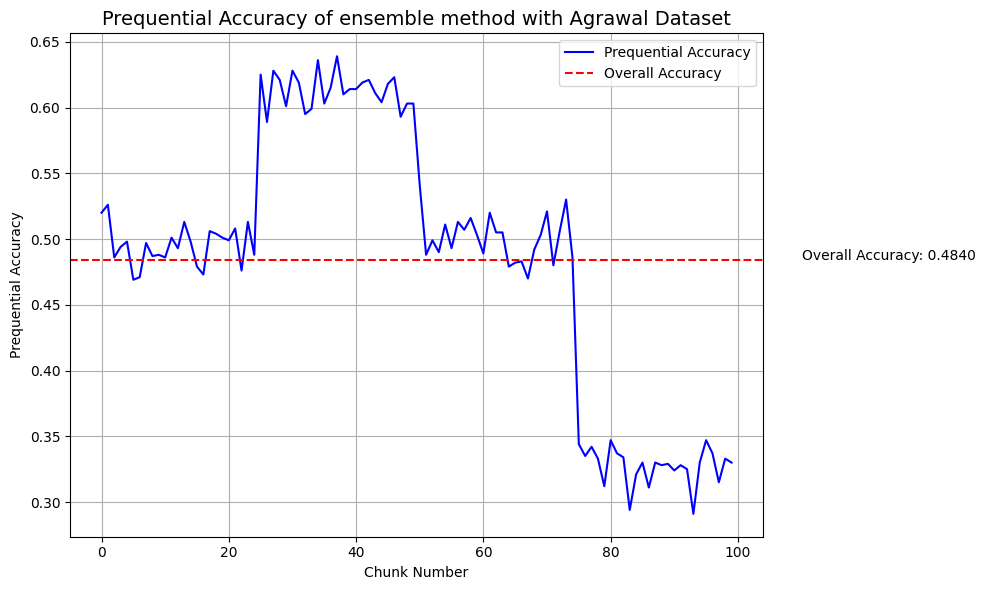

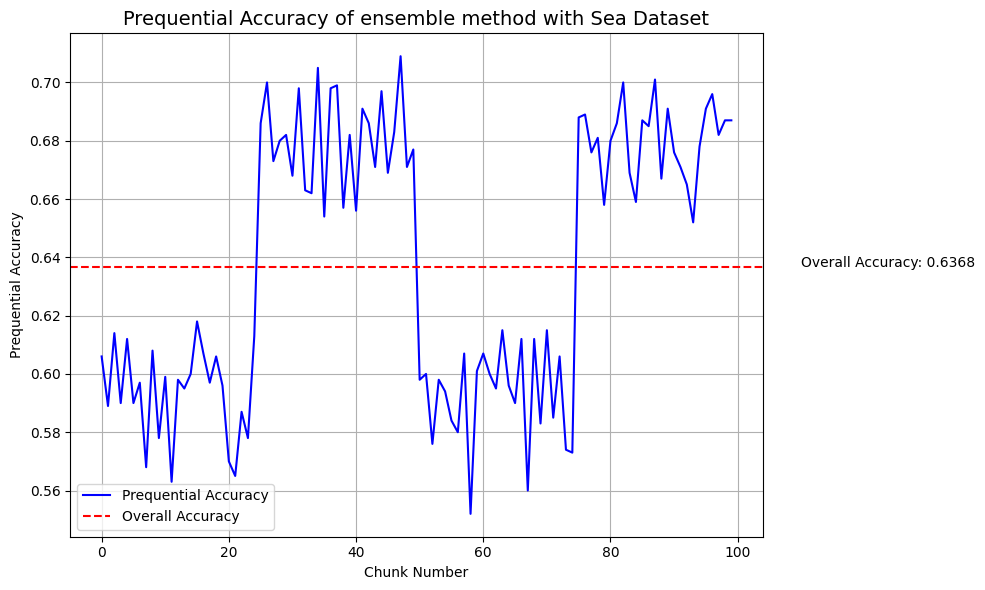

In [ ]:
# Initialize ensemble
base_learner, drift_detector = initialize_ensemble(5)

window_size = 1000

# Iterate over datasets
for df, df_name in datasets:
    # Initialize variables for prequential accuracy calculation
    accuracies = []
    total_accuracy = 0
    total_instances = 0
    chunk_number = 0
    preq_acc_values = []
    # Simulate data stream
    for index, row in df.iterrows():
        X = np.array([row.iloc[:-1]])
        y = np.array([row.iloc[-1]])

        # Perform prediction
        y_pred = predict_ensemble(base_learner,X)

        # Update classifier with current sample
        partial_fit_ensemble(base_learner,drift_detector, X, y)

        # Calculate accuracy
        instance_accuracy = accuracy_score(y, y_pred)
        accuracies.append(instance_accuracy)

        # Update overall accuracy
        total_accuracy += instance_accuracy
        total_instances += 1

        # Calculate prequential accuracy for sliding window
        if len(accuracies) % window_size == 0:
            prequential_accuracy = sum(accuracies[-window_size:]) / window_size
            preq_acc_values.append(prequential_accuracy)

        # Increment chunk number
        chunk_number += 1

    # Calculate overall accuracy
    overall_accuracy = total_accuracy / total_instances

  # Calculate the number of chunks
    num_chunks = len(preq_acc_values)

    # Determine the figure width based on the number of chunks
    if num_chunks < 100:
        fig_width = 10
    else:
        fig_width = num_chunks * 0.1

    # Plot prequential accuracy as a line graph
    plt.figure(figsize=(fig_width, 6))
    plt.plot(np.arange(num_chunks), preq_acc_values, color='b', label='Prequential Accuracy')
    plt.axhline(overall_accuracy, color='r', linestyle='--', label='Overall Accuracy')
    plt.title(f"Prequential Accuracy of ensemble method with {df_name}", fontsize=14)
    plt.xlabel("Chunk Number", fontsize=10)
    plt.ylabel("Prequential Accuracy", fontsize=10)
    plt.text(num_chunks + 0.1 * num_chunks, overall_accuracy, f'Overall Accuracy: {overall_accuracy:.4f}', fontsize=10, color='black')  # Adjust x-coordinate to position the text
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

##C) Implementations for Handling Adversarial Attack

###1) For two synthetic datasets generated in part (A), synthesize a malicious attack in two points.

In [9]:
def malicious_attack(df, start_index, end_index, flip_percentage):
    # Validate input indices
    if start_index < 0 or start_index >= len(df) or end_index < start_index or end_index >= len(df):
        raise ValueError("Invalid start or end index.")

    # Subset the DataFrame for the specified range of instances
    subset = df.iloc[start_index:end_index+1]

    # Determine number of labels to flip
    num_instances = len(subset)
    num_flips = int(num_instances * flip_percentage)

    # Randomly select indices to flip
    flip_indices = np.random.choice(subset.index, num_flips, replace=False)

    # Make a copy of the DataFrame to avoid modifying the original DataFrame
    df_modified = df.copy()

    # Convert label_column to boolean if needed
    if not np.issubdtype(df_modified[df_modified.columns[-1]].dtype, np.bool_):
        df_modified[df_modified.columns[-1]] = df_modified[df_modified.columns[-1]].astype(bool)

    # Flip the labels in the selected indices
    df_modified.loc[flip_indices, df_modified.columns[-1]] = ~df_modified.loc[flip_indices, df_modified.columns[-1]]

    # Convert label_column to float from boolean (original dataset shape)
    df_modified[df_modified.columns[-1]] = df_modified[df_modified.columns[-1]].astype(float)
    return df_modified

In [10]:
# Apply attacks to agrawal_df and sea_df
agrawal_df_at = malicious_attack(agrawal_df, 40000, 40500, 0.1)
agrawal_df_atk = malicious_attack(agrawal_df_at, 60000, 60500, 0.2)
sea_df_at = malicious_attack(sea_df, 40000, 40500, 0.1)
sea_df_atk = malicious_attack(sea_df_at, 60000, 60500, 0.2)

###2) Propose and implement a solution for handling this attack.

In [8]:
def initialize_ensemble_mod(num_learners):
    base_learners = [HoeffdingTreeClassifier() for _ in range(num_learners)]
    drift_detector = ADWIN()
    return base_learners, drift_detector

def partial_fit_ensemble_mod(base_learners, drift_detector, X, y):
    global label_log
    # Check for adversarial attack based on specific criteria
    is_adversarial = detect_label_anomaly_mod(label_log,y,50)
    if not is_adversarial:
        for classifier in base_learners:
            # Update the classifier with the current sample
            clf = classifier.partial_fit(X, y)
        # Make predictions on the updated classifiers
        y_pred = predict_ensemble_mod(base_learners, X)

        drift_detector.add_element(1 if (y_pred == y).all else 0)

        # Check for concept drift using the drift detector
        if drift_detector.detected_change():
            # Reset all base learners if drift is detected
            for classifier in base_learners:
                classifier.reset()

def predict_ensemble_mod(base_learners, X):
    # Collect predictions from each base learner
    predictions = [learner.predict(X) for learner in base_learners]
    # Convert list of predictions into a NumPy array
    predictions_array = np.array(predictions)
    # Find the unique predictions and their counts
    unique_predictions, counts = np.unique(predictions_array, return_counts=True, axis=0)
    # Determine the index of the prediction with the highest count
    majority_index = np.argmax(counts)
    # Get the majority prediction based on the index
    majority_prediction = unique_predictions[majority_index]
    return majority_prediction

def detect_label_anomaly_mod(label_log, current_label, window_size):
    # Update the label log with the current label
    label_log.append(current_label)
    # Trim the label log to the last 'window_size' instances
    label_log = label_log[-window_size:]

    # Perform statistical analysis on the label log
    if len(label_log) >= window_size:
        # Compute variance of label values
        label_variance = np.var(label_log)

        # Compute mode (most frequent label) and its occurrence count
        unique_labels, label_counts = np.unique(label_log, return_counts=True)
        mode_label = unique_labels[np.argmax(label_counts)]
        mode_count = label_counts[np.argmax(label_counts)]

        # Decision criteria based on label variance and mode consistency
        if label_variance > 0.1 or mode_count < 15:
            return True

    return False


In [28]:
# List of DataFrames and their names
datasets = [
    (spam_df, 'Spam Dataset'),
    (elec_df,  'Electric Dataset'),
    (agrawal_df_atk, 'Poisoned Agrawal Dataset'),
    (sea_df_atk, 'Poisoned Sea Dataset')
]


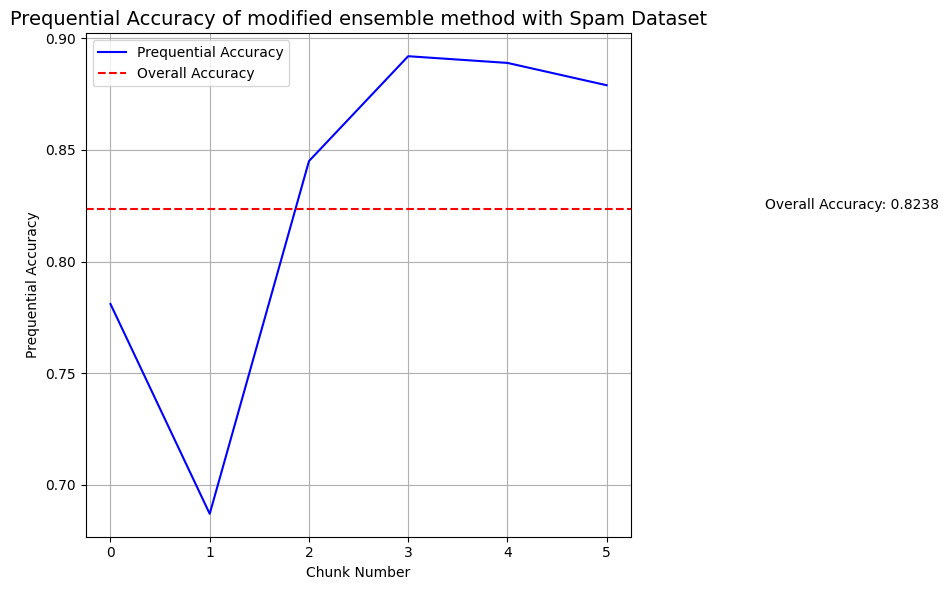

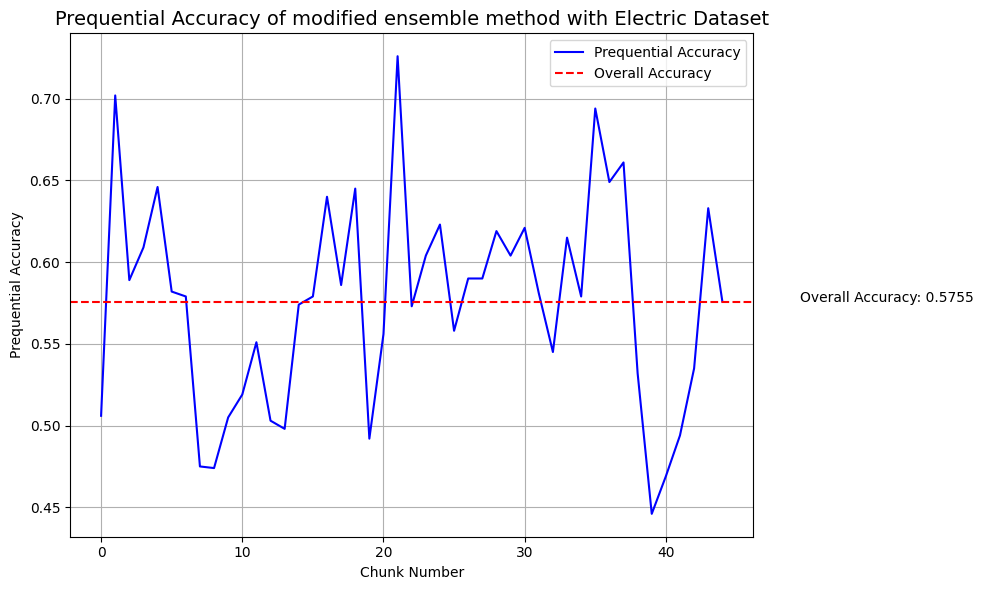

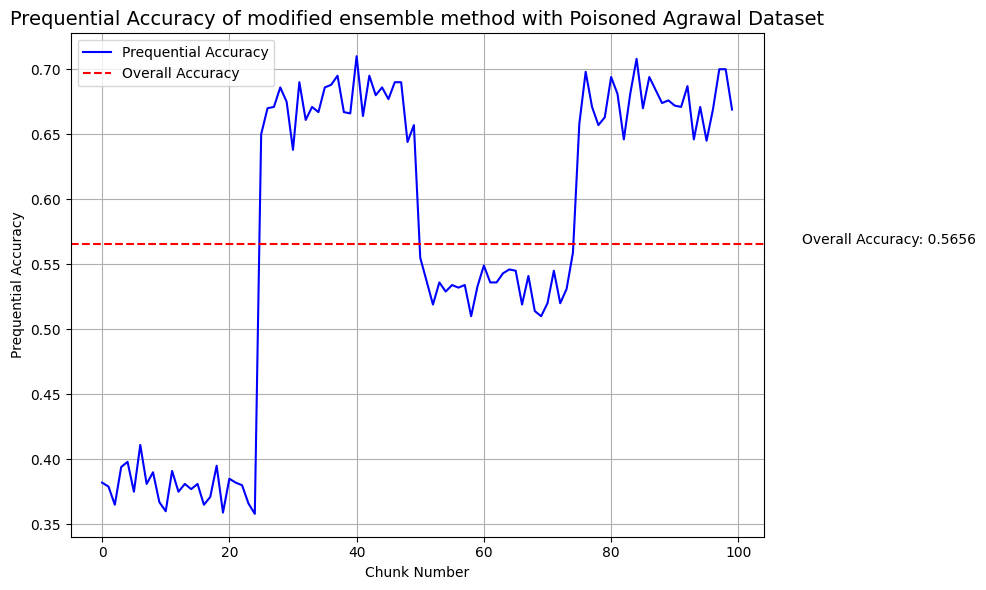

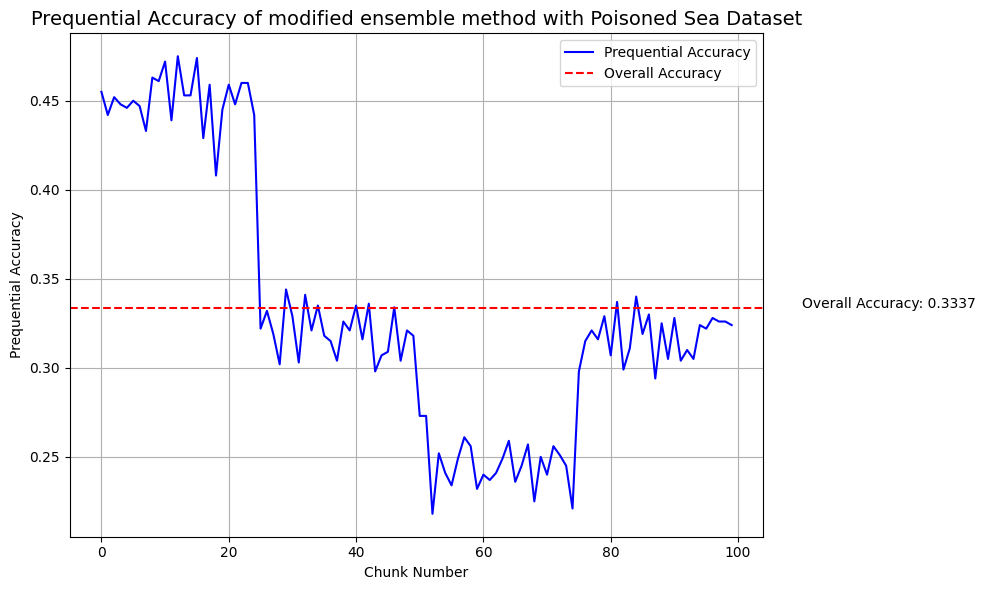

In [31]:
label_log = []
# Initialize ensemble and drift detector
base_learners, drift_detector = initialize_ensemble_mod(5)

window_size = 1000

for df, df_name in datasets:
    accuracies = []
    total_accuracy = 0
    total_instances = 0
    chunk_number = 0
    preq_acc_values = []

    # Simulate data stream processing
    for index, row in df.iterrows():
        X = np.array([row.iloc[:-1]])
        y = np.array([row.iloc[-1]])

        # Perform prediction using the ensemble
        y_pred = predict_ensemble_mod(base_learners, X)

        # Update ensemble classifiers with the current sample and detect label anomaly
        partial_fit_ensemble_mod(base_learners, drift_detector, X, y)

        if df_name == 'Poisoned Agrawal Dataset':
            # Calculate instance accuracy
            instance_accuracy = accuracy_score(np.array([agrawal_df.iloc[index,-1]]), y_pred)
            accuracies.append(instance_accuracy)
        elif df_name == 'Poisoned Sea Dataset':
            # Calculate instance accuracy
            instance_accuracy = accuracy_score(np.array([sea_df.iloc[index,-1]]), y_pred)
            accuracies.append(instance_accuracy)
        else:
            # Calculate instance accuracy
            instance_accuracy = accuracy_score(y, y_pred)
            accuracies.append(instance_accuracy)

        # Update overall accuracy metrics
        total_accuracy += instance_accuracy
        total_instances += 1

        # Calculate prequential accuracy for sliding window
        if len(accuracies) % window_size == 0:
            prequential_accuracy = sum(accuracies[-window_size:]) / window_size
            preq_acc_values.append(prequential_accuracy)

        # Increment chunk number
        chunk_number += 1

    # Calculate overall accuracy
    overall_accuracy = total_accuracy / total_instances

    # Plot prequential accuracy as a line graph
    num_chunks = len(preq_acc_values)
    fig_width = max(num_chunks * 0.1, 10)
    plt.figure(figsize=(fig_width, 6))
    plt.plot(np.arange(num_chunks), preq_acc_values, color='b', label='Prequential Accuracy')
    plt.axhline(overall_accuracy, color='r', linestyle='--', label='Overall Accuracy')
    plt.title(f"Prequential Accuracy of modified ensemble method with {df_name}", fontsize=14)
    plt.xlabel("Chunk Number", fontsize=10)
    plt.ylabel("Prequential Accuracy", fontsize=10)
    plt.text(num_chunks + 0.1 * num_chunks, overall_accuracy, f'Overall Accuracy: {overall_accuracy:.4f}', fontsize=10, color='black')  # Adjust x-coordinate to position the text
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()